# Road lane line detection with Fully Convolutional Networks (FCNs)

We use [this pre-processed TuSimple](https://www.kaggle.com/datasets/hikmatullahmohammadi/tusimple-preprocessed) dataset in this notebook.

In [1]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# training path
train_path = '/kaggle/input/tusimple-dataset-preprocessed/'

In [3]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


Actually, the images do not belong to two classes. Rather, there are two directories, one for images and one for their corresponding lane masks. So in the cell bellow, we handle it: seperate assign the images to X and y

In [4]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [5]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [6]:
# becacuse of lack of resources like RAM, we only get 2500 training samples
X = np.array(X[:2500])
Y = np.array(Y[:2500])

In [7]:
display(X.shape)
display(Y.shape)

(2500, 256, 320, 3)

(2500, 256, 320)

# Modeling

In [8]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [9]:
Y.min(), Y.max()

(0, 1)

In [10]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [11]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (2250, 256, 320, 3)
Shape of X_val: (250, 256, 320, 3)
Shape of Y_train: (2250, 256, 320, 1)
Shape of Y_val: (250, 256, 320, 1)


In [12]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

0

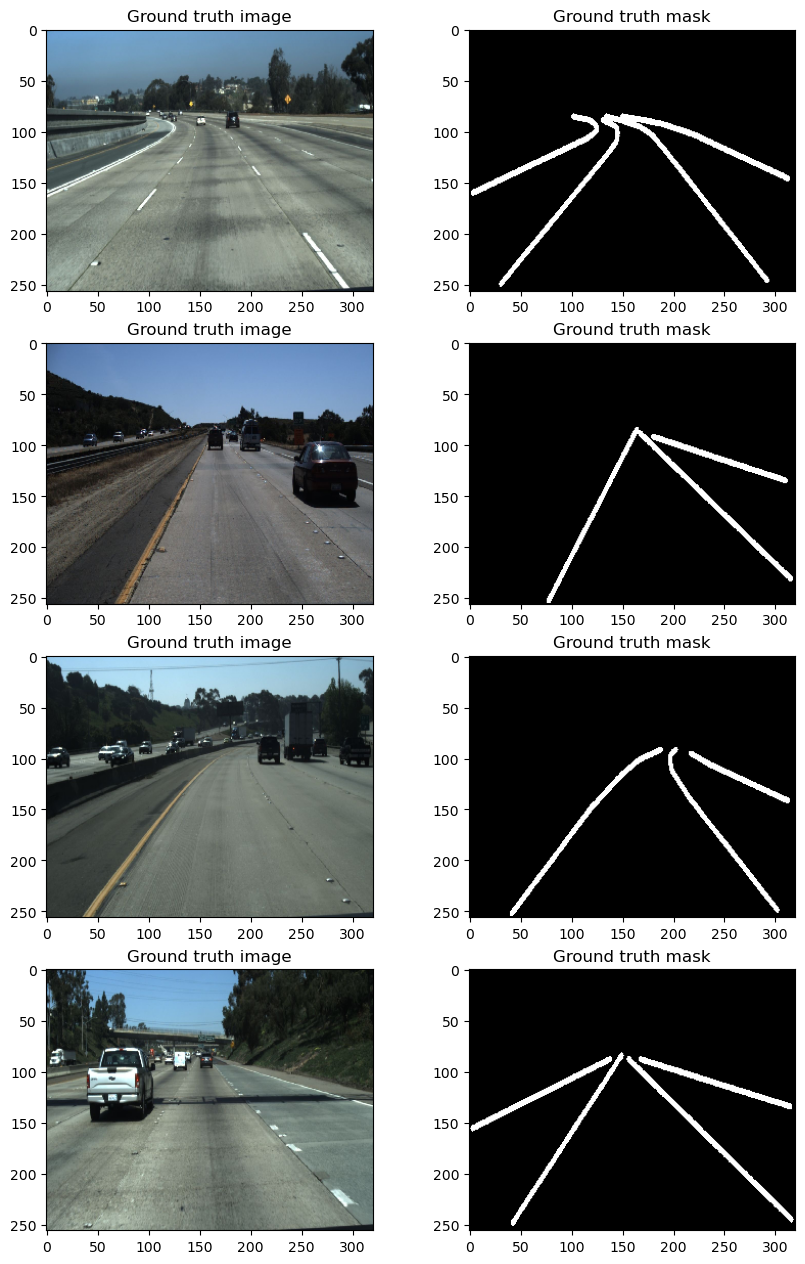

In [13]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [14]:
# model structure
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

# Define the input shape of the images
input_shape = (256, 320, 3)

# Define the encoder using a pretrained ResNet50 model
encoder = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

'''
Find the index of the layer named conv3_block4_out of which output size is (32x32xnC)
 because we want to shrink the input's size down upto (32x32xnC) in the encoder section
'''

for i, layer in enumerate(encoder.layers):
    if layer.name == 'conv3_block4_out':
        break

# Create a new model that includes only the layers up to conv3_block4_out
encoder = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[i].output)

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in encoder.layers[:50]:
    layer.trainable = False

# Define the decoder using a smaller FCN architecture
def decoder(inputs):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    up1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2)
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)
    return outputs

# Define the input tensor
inputs = Input(input_shape)

# Pass the input through the encoder and decoder to obtain the output
outputs = decoder(encoder(inputs))

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 320, 3)]     0         
                                                                 
 model (Functional)          (None, 32, 40, 512)       1460096   
                                                                 
 conv2d (Conv2D)             (None, 32, 40, 256)       1179904   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 80, 256)      262400    
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 80, 128)       295040    
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 160, 128)    65664     
 ranspose)                                                 

In [16]:
# train the model
epochs = 32
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/32
282/282 [==============================] - 61s 121ms/step - loss: 0.0189 - accuracy: 0.9700 - val_loss: 0.0159 - val_accuracy: 0.9757
Epoch 2/32
282/282 [==============================] - 30s 108ms/step - loss: 0.0137 - accuracy: 0.9780 - val_loss: 0.0148 - val_accuracy: 0.9768
Epoch 3/32
282/282 [==============================] - 30s 108ms/step - loss: 0.0126 - accuracy: 0.9795 - val_loss: 0.0137 - val_accuracy: 0.9787
Epoch 4/32
282/282 [==============================] - 31s 109ms/step - loss: 0.0117 - accuracy: 0.9808 - val_loss: 0.0136 - val_accuracy: 0.9788
Epoch 5/32
282/282 [==============================] - 31s 110ms/step - loss: 0.0109 - accuracy: 0.9818 - val_loss: 0.0144 - val_accuracy: 0.9788
Epoch 6/32
282/282 [==============================] - 31s 111ms/step - loss: 0.0102 - accuracy: 0.9829 - val_loss: 0.0139 - val_accuracy: 0.9784
Epoch 7/32
282/282 [==============================] - 32s 115ms/step - loss: 0.0097 - accuracy: 0.9839 - val_loss: 0.0151 - val_ac

In [17]:
preds = model.predict(X_val)
preds.max(), preds.min()

8/8 [==============================] - 8s 544ms/step


(0.999938, 5.4877365e-20)

In [18]:
# make a directory to store some predicted lane masks
!mkdir out

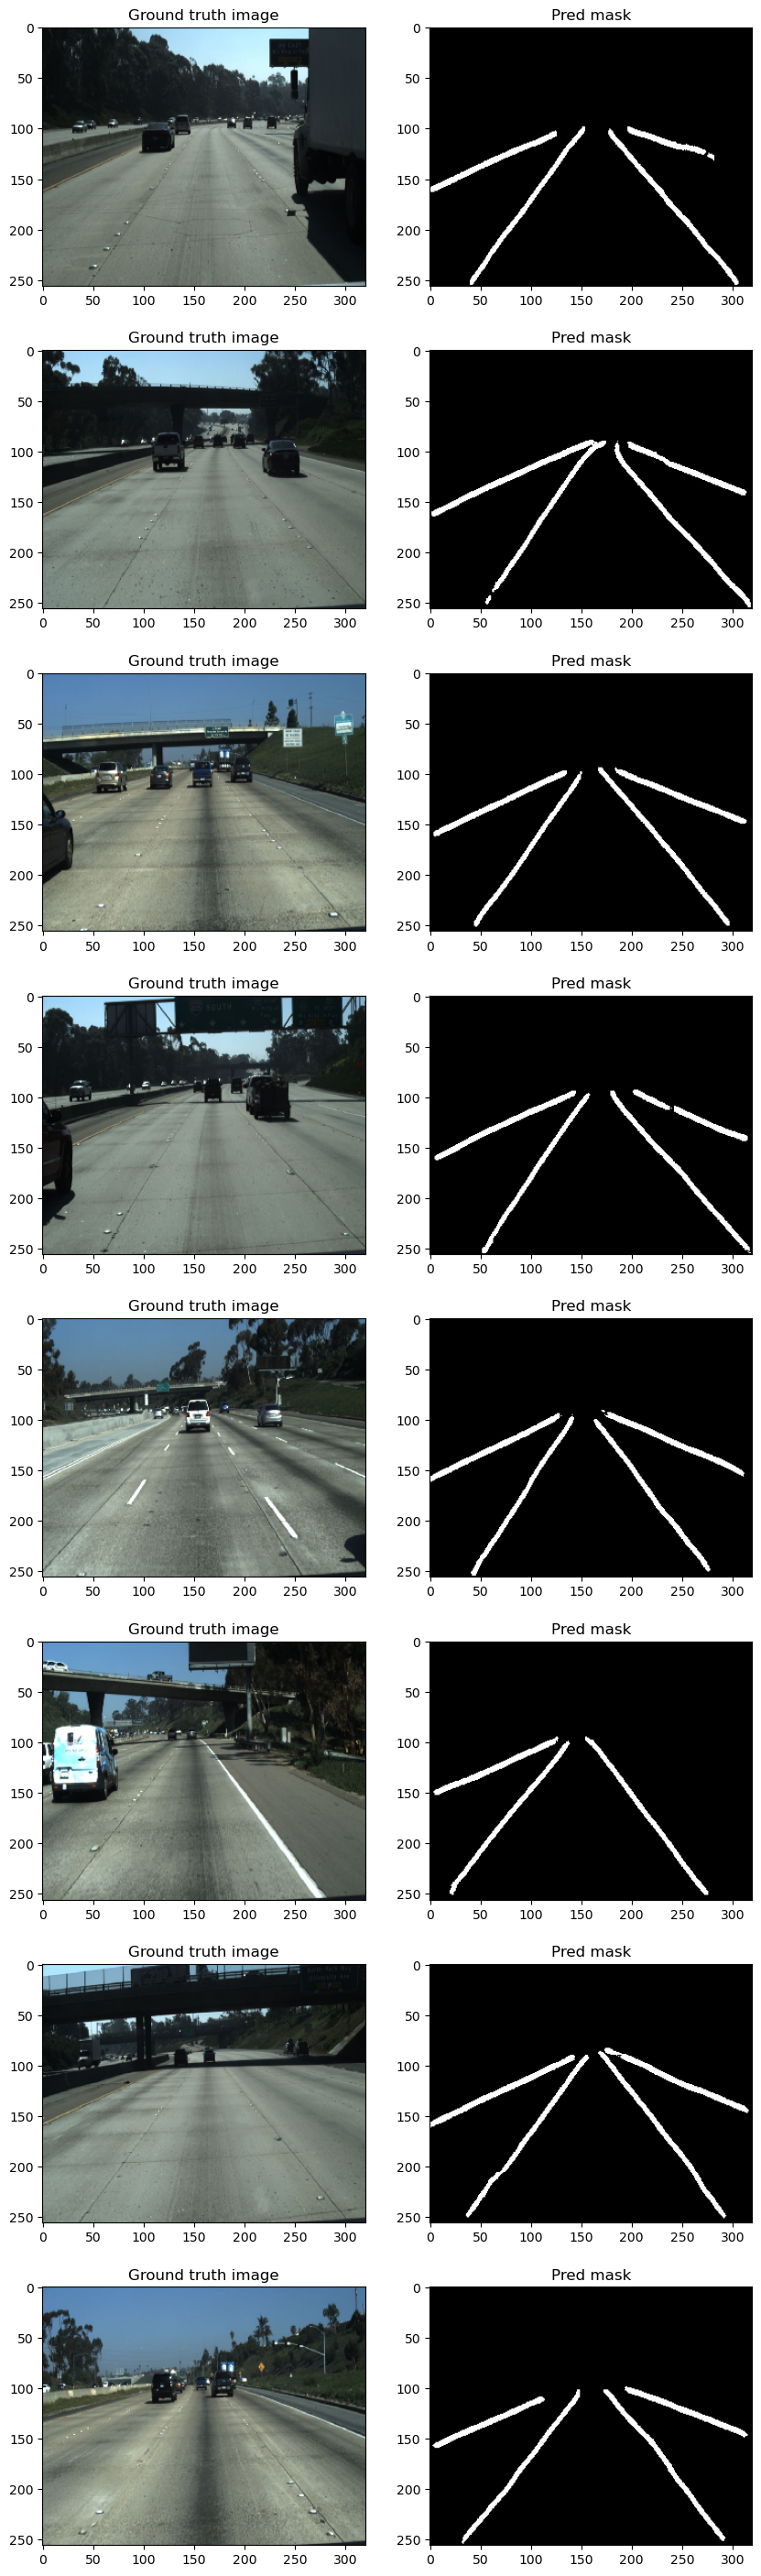

In [19]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [20]:
# zip 'out' folder
!zip out.zip out -r -q

In [21]:
# save the model
model.save('/lane-detection-model-fcn')

In [22]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.97849685
Precision: 0.75798047
Recal: 0.73222053
F1 Score:  0.744877852303931
IoU:  0.5934704


---

The notebook is authored by: [Hikmatullah Mohammadi](https://www.linkedin.com/in/hikmatullah-mohammadi-871550225/)